In [4]:
import sys
sys.path.append('../../DeepCell')

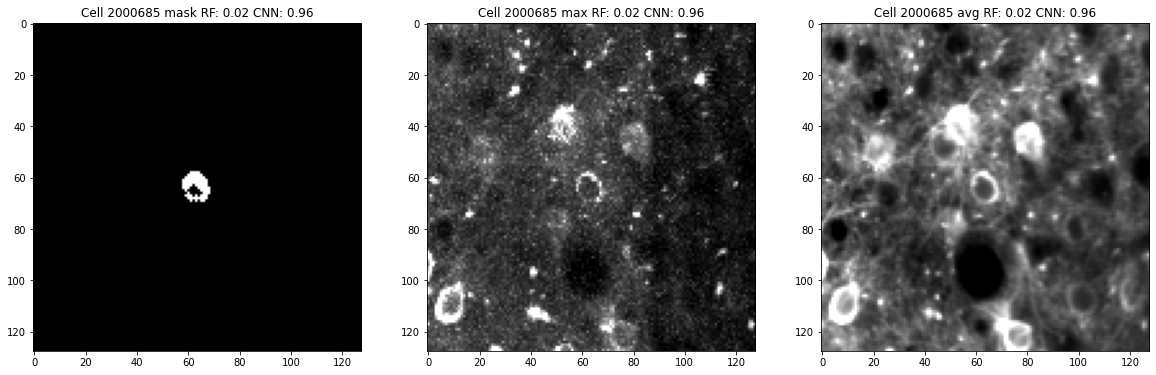

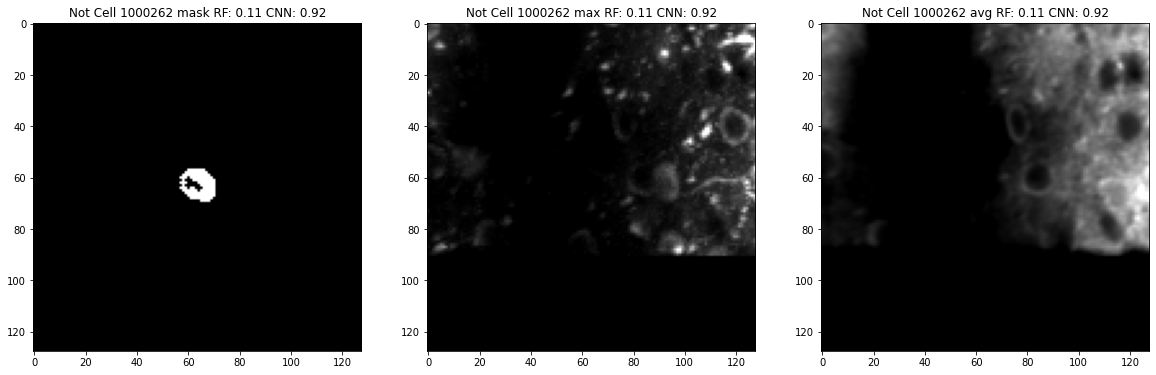

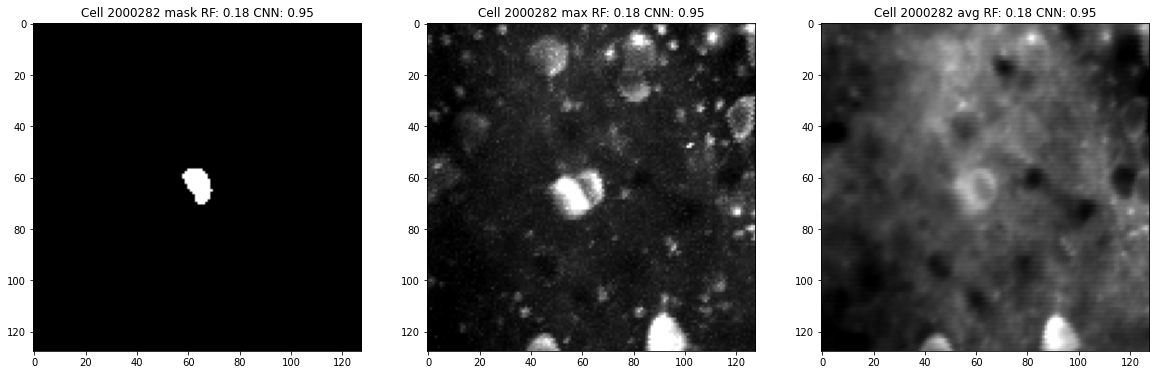

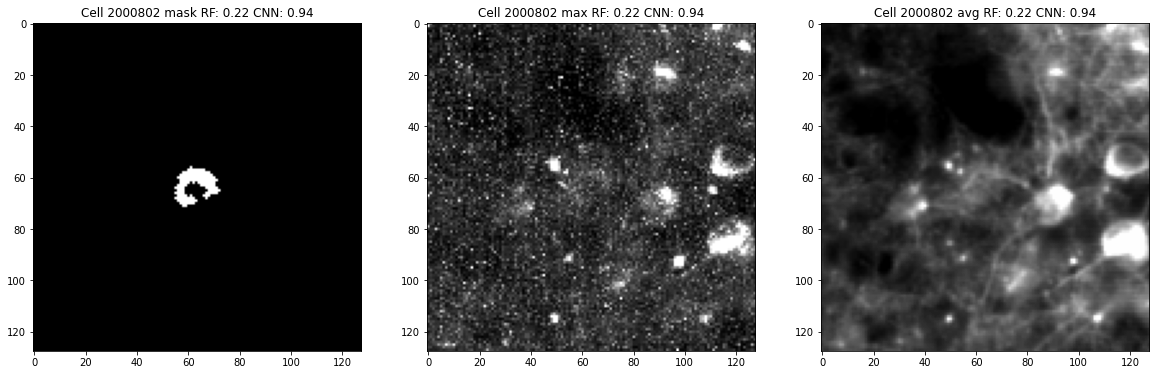

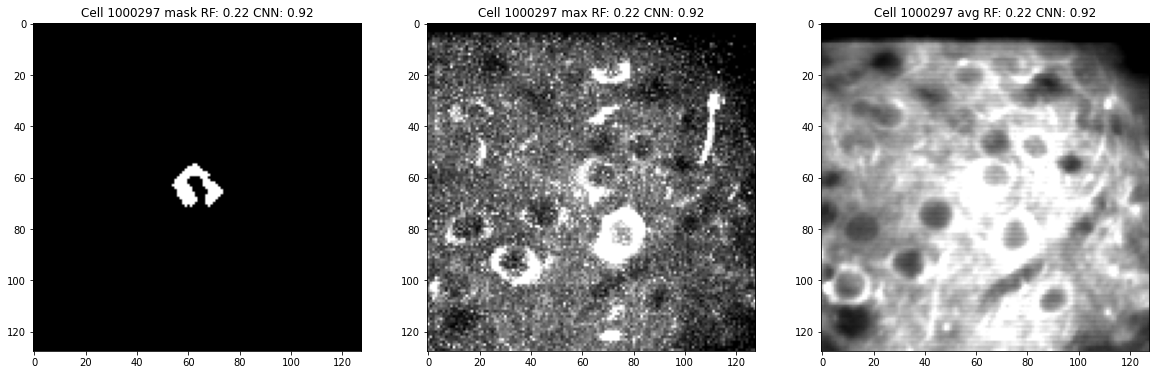

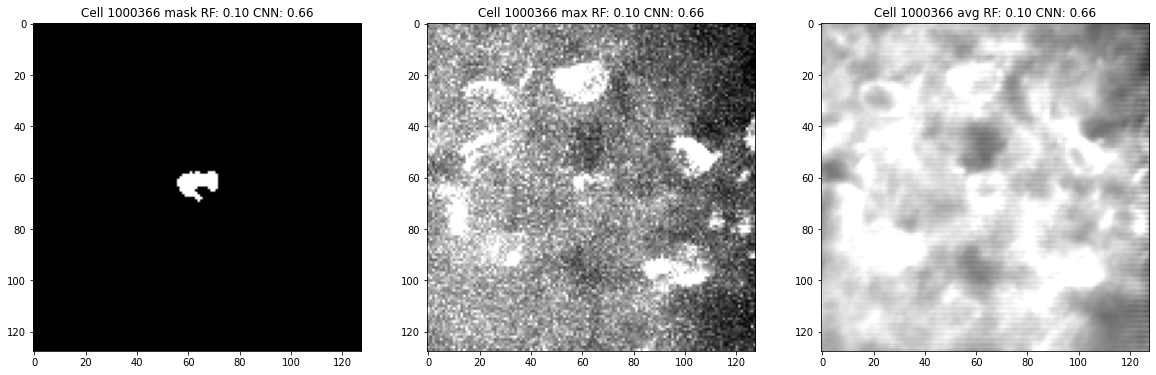

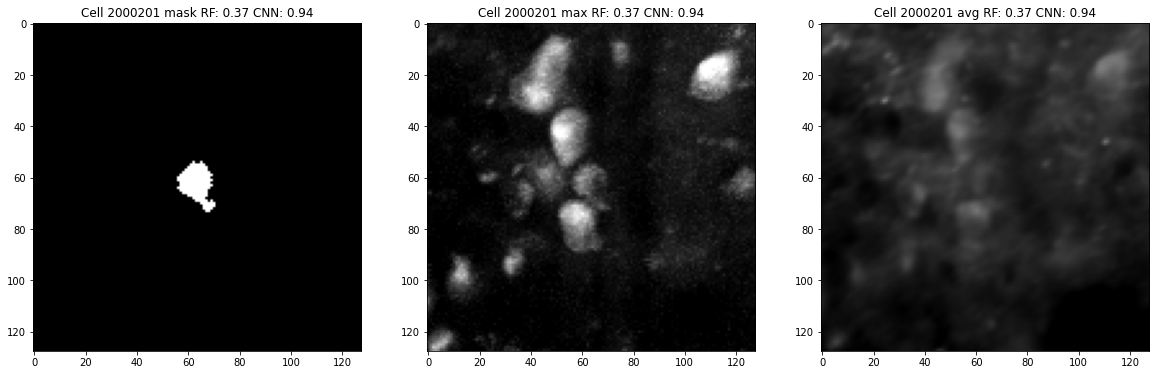

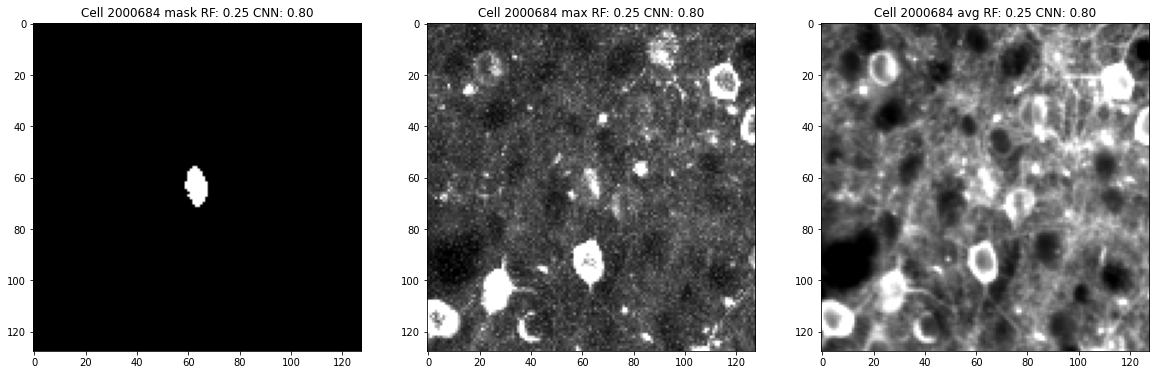

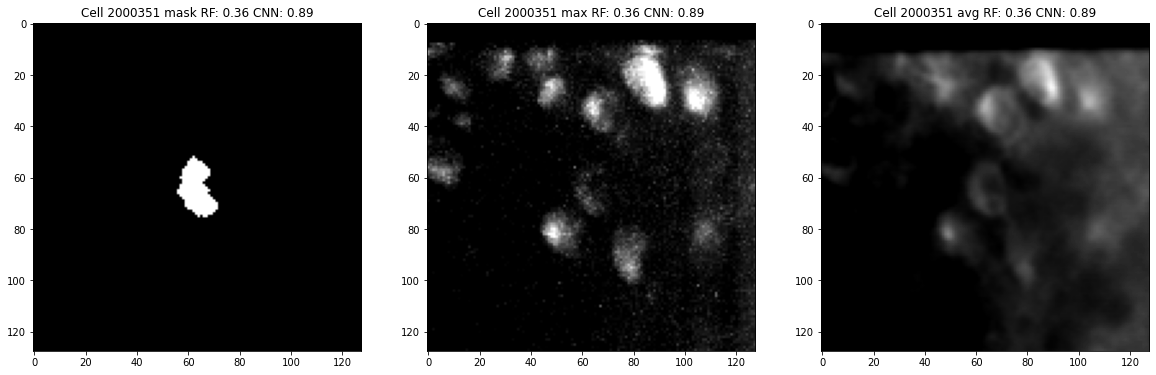

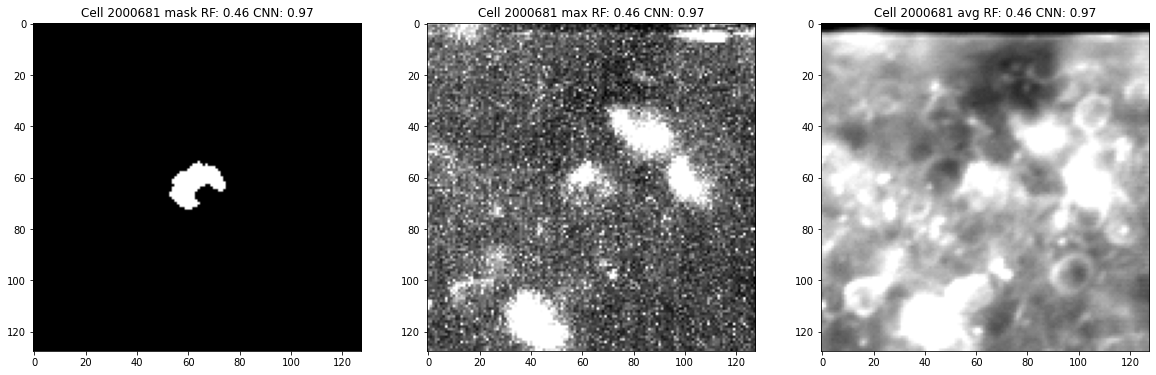

In [11]:
import pandas as pd
from torchvision import transforms
from imgaug import augmenters as iaa
import numpy as np

from DataSplitter import DataSplitter
from Transform import Transform
from eda import display_roi

project_name = 'ophys-experts-slc-oct-2020_ophys-experts-go-big-or-go-home'
manifest_path = 's3://prod.slapp.alleninstitute.org/behavior_slc_oct_2020_behavior_3cre_1600roi_merged/output.manifest'

all_transform = transforms.Compose([
    iaa.Sequential([
        iaa.CenterCropToFixedSize(height=30, width=30)
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Transform(all_transform=all_transform)

data_splitter = DataSplitter(manifest_path=manifest_path, project_name=project_name,
                             test_transform=test_transform, seed=1234, data_dir='../data')
train, test = data_splitter.get_train_test_split(test_size=.3)

def calc_perf(df, for_='cnn'):
    y_pred = df['y_pred_cnn'] if for_ == 'cnn' else df['y_pred_rf']

    TP = ((df['y_true'] == 1) & (y_pred == 1)).sum()
    FP = ((df['y_true'] == 0) & (y_pred == 1)).sum()
    FN = ((df['y_true'] == 1) & (y_pred == 0)).sum()

    p = TP / (TP + FP)
    r = TP / (TP + FN)

    return p, r

def main():
    cnn_preds = pd.read_csv('~/Downloads/test_preds.csv')
    cnn_preds = cnn_preds.rename(columns={'roi-id': 'roi_id'})

    rf_preds = pd.read_csv('~/Downloads/labels.txt')
    rf_preds.columns = [c.strip() for c in rf_preds.columns]
    rf_preds = rf_preds.rename(columns={
        '#roi_id': 'roi_id',
        'truth': 'y_true',
        'prediction': 'y_pred',
        'prob_cell': 'y_score'
    })
    rf_preds = rf_preds.drop('prob_not_cell', axis=1)

    df = cnn_preds.merge(rf_preds, on='roi_id', suffixes=('_cnn', '_rf'))
    df = df.rename(columns={'y_true_cnn': 'y_true'})
    df = df.drop(['y_true_rf'], axis=1)

#     print(calc_perf(df=df, for_='cnn'))
#     print(calc_perf(df=df, for_='rf'))
    
    df['diff'] = (df['y_score_cnn'] - df['y_score_rf']).abs()
    df.to_csv('~/Downloads/compare_rf.csv')
    
    differ = df[df['y_pred_cnn'] != df['y_pred_rf']]
    differ = differ.sort_values('diff', ascending=False)

    for row in differ[:10].itertuples():
        roi_id = row.roi_id
        channels = train._extract_channels(obs={'roi-id': roi_id})
        label = 'Cell' if row.y_true == 1 else 'Not Cell'
        y_pred = f'RF: {row.y_score_rf:.2f} CNN: {row.y_score_cnn:.2f}'
        display_roi(channels=channels, roi_id=roi_id,
                    columns=3, rows=1, label=label, y_pred=y_pred)
main()